<h2 align="center", style="font-size:28px">Vergleich maschineller Lernalgorithmen für die Vorhersage von Stromverbrauch</h2><h3 align="center", style="font-size:20px"><I>Fallbeispiel - Stadt Tétouan in Marokko </I></h3>

<hr style="border-width: 3px;border-color: #ff0000;" >
<h3><center>Maschinelle Lernalgorithmen - <I>Part II </I>- </center></h3>
<hr style="border-width: 3px;border-color: #ff0000;" >

<span style="font-size:18px">Einsatz von folgenden Lernalgorithmen:</span>
<ul style="font-size:18px">
    <li>Lineare Regression</li>
    <li>K-Nächste-Nachbarn - KNN</li>
    <li>Support Vector Machine - SVR</li>
    <li>Entscheidungsmbaum - Decision Tree</li>
    <li>Random Forest</li>
</ul>

In [63]:
# - Import Bibliotheken -

# Datenaufbereitung
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

# Modellbildung
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Warnungen
import warnings
warnings.filterwarnings('ignore')

#Standard-Parameter
from pprint import pprint

In [55]:
#Daten Laden
data_path = "C:\\Users\\Maxim\\Desktop\\Abschlussarbeit\\Tetuan City power consumption.csv"
df_power = pd.read_csv(data_path,parse_dates=True,index_col="DateTime")
df_power.rename({'Zone 1 Power Consumption': 'Quads', 'Zone 2  Power Consumption': 'Boussafou', 'Zone 3  Power Consumption': 'Smir' }, axis=1, inplace=True)
df_power.head().round(2)

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Quads,Boussafou,Smir
DateTime,,,,,,,,
2017-01-01 00:00:00,6.56,73.8,0.08,0.05,0.12,34055.70,16128.88,20240.96
2017-01-01 00:10:00,6.41,74.5,0.08,0.07,0.08,29814.68,19375.08,20131.08
2017-01-01 00:20:00,6.31,74.5,0.08,0.06,0.10,29128.10,19006.69,19668.43
2017-01-01 00:30:00,6.12,75.0,0.08,0.09,0.10,28228.86,18361.09,18899.28
2017-01-01 00:40:00,5.92,75.7,0.08,0.05,0.08,27335.70,17872.34,18442.41


In [57]:
#Datum parsen 
for i in range(len(df_power)):
    position = df_power.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_power.loc[position, 'hour'] = hour
    df_power.loc[position, 'weekday'] = weekday+1
    df_power.loc[position, 'month'] = month
    
df_power['hour'] = df_power['hour'].apply(np.int64)
df_power['weekday'] = df_power['weekday'].apply(np.int64)
df_power['month'] = df_power['month'].apply(np.int64)

df_power.head().round(2)

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Quads,Boussafou,Smir,hour,weekday,month
DateTime,,,,,,,,,,,
2017-01-01 00:00:00,6.56,73.8,0.08,0.05,0.12,34055.70,16128.88,20240.96,0,7,1
2017-01-01 00:10:00,6.41,74.5,0.08,0.07,0.08,29814.68,19375.08,20131.08,0,7,1
2017-01-01 00:20:00,6.31,74.5,0.08,0.06,0.10,29128.10,19006.69,19668.43,0,7,1
2017-01-01 00:30:00,6.12,75.0,0.08,0.09,0.10,28228.86,18361.09,18899.28,0,7,1
2017-01-01 00:40:00,5.92,75.7,0.08,0.05,0.08,27335.70,17872.34,18442.41,0,7,1


<h4>Modellbildung mit den Default-Hyperparametern</h4>

In [131]:
#Um Rechenaufwand zu reduzieren: Downsamplen von der 10-Minuten in eine stündliche Frequenz , 
df_power_hour = df_power.resample('h').mean() 
df_power_hour.shape

(8736, 11)

In [144]:
def modelliere(df,y):

    #Modelle definieren mit Standard-Hyperparametern
    knn  = KNeighborsRegressor()
    dt   = DecisionTreeRegressor() 
    lreg = LinearRegression()
    svr  = SVR()
    rdf  = RandomForestRegressor()

    regs =[]
    res_new_train=[]
    mses_new_test=[]
    res_new_test=[]
    
    #Datensatz in Trainings-und Testdaten aufteilen
    X = df.drop(['Humidity','Quads','Boussafou','Smir'], axis = 1)
    y = df[y]
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
    
    #Trainingsdaten normalisieren
    mmscaler = MinMaxScaler()
    x_train_norm = mmscaler.fit_transform(x_train)
    x_test_norm = mmscaler.transform(x_test)

    for reg in (knn, dt, lreg, svr, rdf):
        reg.fit(x_train_norm, y_train)
        y_pred = reg.predict(x_test_norm)

        #Modellleistung: Trainingsdaten
        re_train = round(reg.score(x_train_norm, y_train),4)*100
        #Modellleistung: Testdaten
        mse_test = round(mean_squared_error(y_test,y_pred),2)
        re_test = round(reg.score(x_test_norm, y_test),4)*100

        regs.append(reg.__class__.__name__)
        res_new_train.append(re_train)
        mses_new_test.append(mse_test)
        res_new_test.append(re_test)
        
        if reg == lreg:
            #Linear Regression modell interpretation
            coefs = pd.DataFrame(lreg.coef_, columns=['Coeff.'], index=x_train.columns)
            coefs.plot(kind='barh', figsize=(9, 7))
            plt.axvline(x=0, color='.5')
            plt.axvline(x=0, color='.5')
            plt.subplots_adjust(left=.3)
            plt.title('Modell: lineare Regression')
            plt.show()
            
        elif reg == rdf:
            #Random Forest Regression modell interpretation
            importances = pd.Series(data=rdf.feature_importances_,index= x_train.columns)
            # Sort importances
            importances_sorted = importances.sort_values()
            plt.figure(figsize=(7,6))
            # Draw a horizontal barplot of importances_sorted
            importances_sorted.plot(kind='barh', color='lightblue')
            plt.title('Modell: Random Forest')
            plt.show()

    res_res_train=[i for i, j in enumerate(res_new_train) if j == max(res_new_train) ]
    res_mses_test=[i for i, j in enumerate(mses_new_test) if j == min(mses_new_test) ]
    res_res_test=[i for i, j in enumerate(res_new_test) if j == max(res_new_test) ]
     
    if regs[res_mses_test[0]] != regs[res_res_test[0]]:
        print (f'Das Modell mit dem niedrigen MSE ist \033[1m{regs[res_mses_test[0]]}\033[0m und \n das Modell mit dem höchsten R² ist \033[1m{regs[res_res_test[0]]}\033[0m\n') 
    else:
        print (f'Das Modell mit dem niedrigen\033[1m MSE: {min(mses_new_test):.2f}\033[0m und dem höchsten \033[1mR²: {max(res_new_test):.2f}%\033[0m ist \033[1m{regs[res_res_test[0]]}\033[0m\n') 
    
    #Result as Dataframe
    dic = {'Modell':regs,'R²% Train':res_new_train,'MSE':mses_new_test,'R²% Test':res_new_test}
    df = pd.DataFrame(dic)
    df.index = df.index + 1
    return df

*****
Mean square Error(MSE): Wie weit weichen die Daten von der Vorhersage ab?
Bestimmtheitsmaß R²: Wieviel Streuung kann das Modell erklären?
*****

Für die Region Quads:
--- Features Importance ---


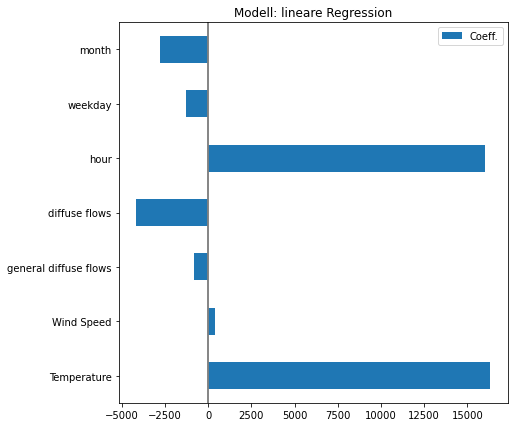

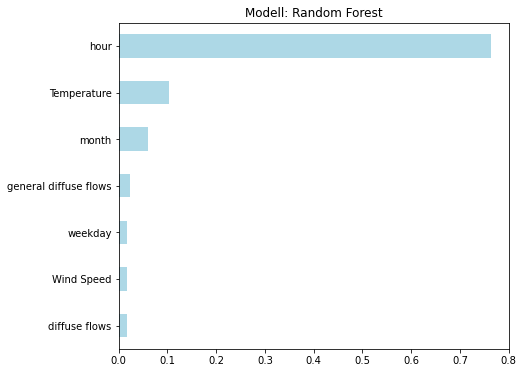

Das Modell mit dem niedrigen MSE: 2439735.08 und dem höchsten R²: 94.95% ist RandomForestRegressor

*****
Für die Region Smir:
--- Features Importance ---


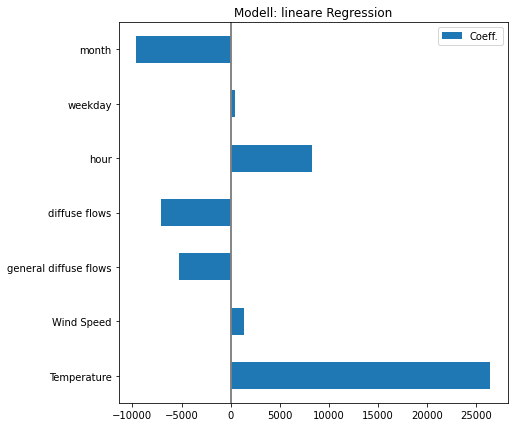

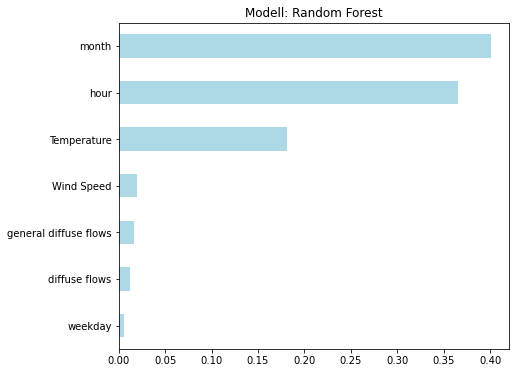

Das Modell mit dem niedrigen MSE: 1637432.61 und dem höchsten R²: 96.15% ist RandomForestRegressor

*****
Für die Region Boussafou:
--- Features Importance ---


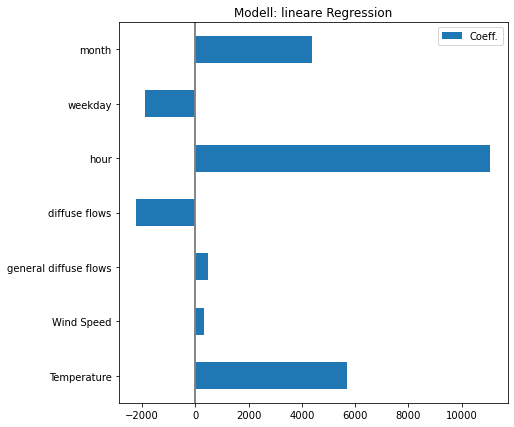

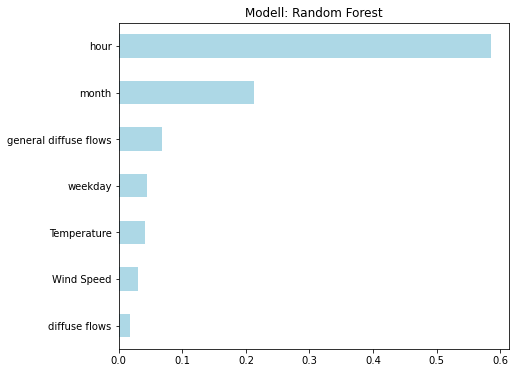

Das Modell mit dem niedrigen MSE: 1359847.89 und dem höchsten R²: 94.78% ist RandomForestRegressor



In [146]:
#Bewertungsmetriken
print('*****\n\033[1mMean square Error(MSE)\033[0m: Wie weit weichen die Daten von der Vorhersage ab?')
print('\033[1mBestimmtheitsmaß R²\033[0m: Wieviel Streuung kann das Modell erklären?\n*****\n')

#Modellbildung
print(f'Für die Region \033[1mQuads\033[0m:\n--- Features Importance ---')
Quads = modelliere(df_power_hour,'Quads')
print(f'*****\nFür die Region \033[1mSmir\033[0m:\n--- Features Importance ---')
Smir = modelliere(df_power_hour,'Smir')
print(f'*****\nFür die Region \033[1mBoussafou\033[0m:\n--- Features Importance ---')
Boussafou= modelliere(df_power_hour,'Boussafou')

In [140]:
#Quads: Modellleistung als Heatmap 
cm = sns.light_palette("green", as_cmap=True)
Quads.style.background_gradient(cmap=cm).set_precision(2).highlight_null('red').highlight_min(axis=0, color='lightblue').highlight_max(axis=0, color='blue').set_table_attributes("style='display:inline'").set_caption('Quads: Modellleistung mit Default-Hyperparametern')

,Modell,R²% Train,MSE,R²% Test
1,KNeighborsRegressor,93.72,5002572.20,89.64
2,DecisionTreeRegressor,100.00,4815545.69,90.02
3,LinearRegression,65.84,17090061.12,64.59
4,SVR,6.81,44939633.63,6.89
5,RandomForestRegressor,99.31,2426440.28,94.97


In [141]:
#Smir: Modellleistung als Heatmap 
Smir.style.background_gradient(cmap=cm).set_precision(2).highlight_null('red').highlight_min(axis=0, color='lightblue').highlight_max(axis=0, color='blue').set_table_attributes("style='display:inline'").set_caption('Smir: Modellleistung mit Default-Hyperparametern')

,Modell,R²% Train,MSE,R²% Test
1,KNeighborsRegressor,93.44,4746561.27,88.84
2,DecisionTreeRegressor,100.00,3156490.04,92.58
3,LinearRegression,61.14,16847665.18,60.38
4,SVR,0.30,42943474.85,-0.98
5,RandomForestRegressor,99.49,1672920.78,96.07


In [142]:
#Boussafou: Modellleistung als Heatmap 
Boussafou.style.background_gradient(cmap=cm).set_precision(2).highlight_null('red').highlight_min(axis=0, color='lightblue').highlight_max(axis=0, color='blue').set_table_attributes("style='display:inline'").set_caption('Boussafou: Modellleistung mit Default-Hyperparametern')

,Modell,R²% Train,MSE,R²% Test
1,KNeighborsRegressor,92.49,3179473.51,87.80
2,DecisionTreeRegressor,100.00,2581019.10,90.09
3,LinearRegression,60.10,10723299.24,58.84
4,SVR,8.51,23864720.79,8.40
5,RandomForestRegressor,99.21,1369926.73,94.74


<h4>Modellleistung des SVR-Modells durch Kreuzvalidierung und Rastersuche verbessern</h4>

<h5>1. Region: Quads</h5>

In [123]:
# Support Vector Regressor
param_grid = {'C':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear'],
              'epsilon':[0.1,0.2,0.5,0.3],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
svr = SVR()
grid_search=GridSearchCV(estimator = svr, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

#Datensatz in Trainings-und Testdaten aufteilen
X = df_power_hour.drop(['Humidity','Quads','Boussafou','Smir'], axis = 1)
y = df_power_hour['Quads']
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
    
#Trainingsdaten normalisieren
mmscaler = MinMaxScaler()
x_train_norm = mmscaler.fit_transform(x_train)
x_test_norm = mmscaler.transform(x_test)
    
grid_search.fit(x_train_norm, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 100, 1000],
                         'epsilon': [0.1, 0.2, 0.5, 0.3],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             verbose=2)

In [124]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mse = round(mean_squared_error(y_test,predictions),2)
    re= round(model.score(x_test_norm, y_test),4)*100
    print('Modellleistung:',model)
    print('MSE: {:0.4f} '.format(mse))
    print('R² = {:0.2f}%.'.format(re))

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test_norm, y_test)
grid_accuracy 

Modellleistung: SVR(C=1000, epsilon=0.5, gamma=1)
MSE: 12448103.8700 
R² = 74.21%.


<h5>2. Region: Smir</h5>

In [125]:
#Support Vector Regressor
param_grid = {'C':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear'],
              'epsilon':[0.1,0.2,0.5,0.3],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
svr = SVR()
grid_search=GridSearchCV(estimator = svr, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

#Datensatz in Trainings-und Testdaten aufteilen
X = df_power_hour.drop(['Humidity','Quads','Boussafou','Smir'], axis = 1)
y = df_power_hour['Smir']
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
    
#Trainingsdaten normalisieren
mmscaler = MinMaxScaler()
x_train_norm = mmscaler.fit_transform(x_train)
x_test_norm = mmscaler.transform(x_test)
    
grid_search.fit(x_train_norm, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 100, 1000],
                         'epsilon': [0.1, 0.2, 0.5, 0.3],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             verbose=2)

In [126]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test_norm, y_test)
grid_accuracy

Modellleistung: SVR(C=1000, epsilon=0.5, gamma=1)
MSE: 10338256.1600 
R² = 75.69%.


<h5>3. Region: Boussafou</h5>

In [127]:
#Support Vector Regressor
param_grid = {'C':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear'],
              'epsilon':[0.1,0.2,0.5,0.3],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
svr = SVR()
grid_search=GridSearchCV(estimator = svr, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

#Datensatz in Trainings-und Testdaten aufteilen
X = df_power_hour.drop(['Humidity','Quads','Boussafou','Smir'], axis = 1)
y = df_power_hour['Boussafou']
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
    
#Trainingsdaten normalisieren
mmscaler = MinMaxScaler()
x_train_norm = mmscaler.fit_transform(x_train)
x_test_norm = mmscaler.transform(x_test)
    
grid_search.fit(x_train_norm, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 100, 1000],
                         'epsilon': [0.1, 0.2, 0.5, 0.3],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             verbose=2)

In [149]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test_norm, y_test)
grid_accuracy

Modellleistung: SVR(C=1000, gamma=1)
MSE: 7040840.6100 
R² = 72.98%.
